gone through  0 training images
gone through  10000 training images
gone through  20000 training images
gone through  30000 training images
gone through  40000 training images


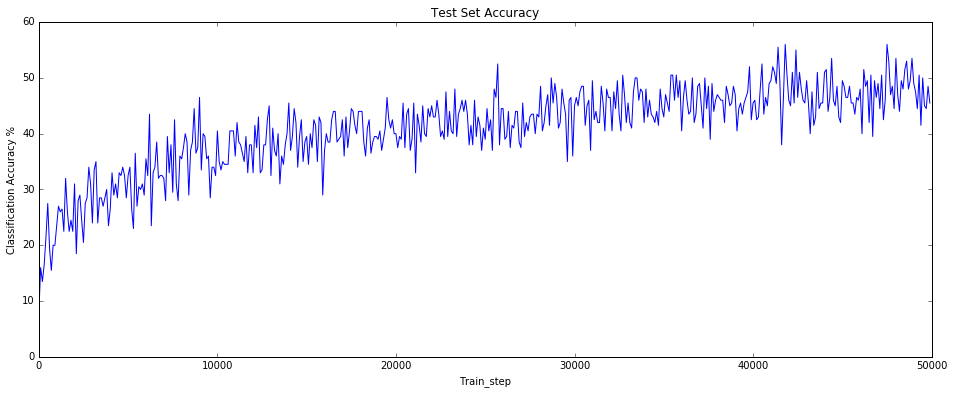

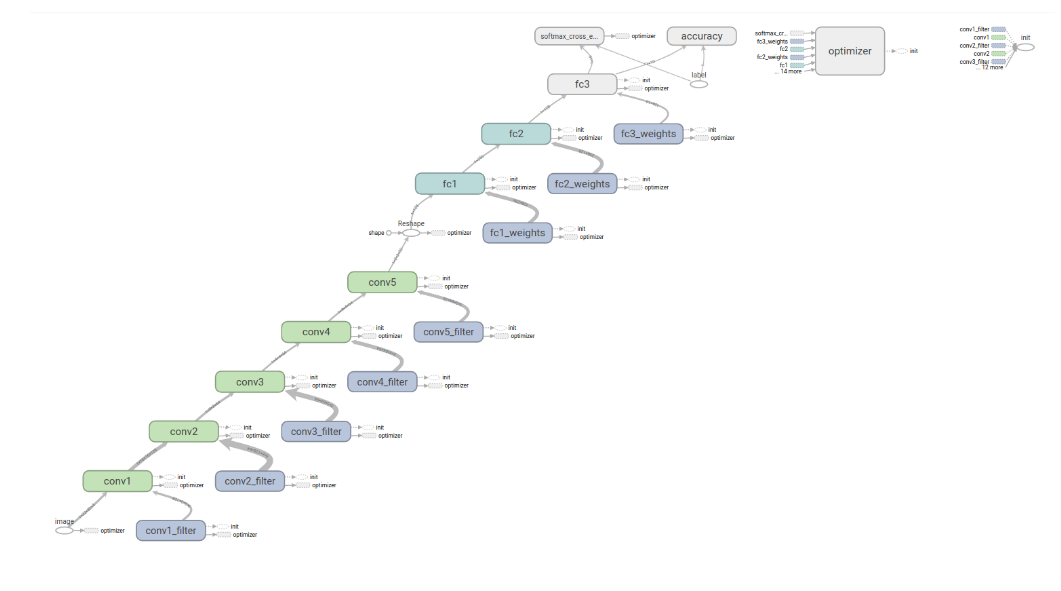

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pdb
import Image
import matplotlib.image as mpimg
tf.reset_default_graph()
#----------------------------------CONVOLUTION FUNCTION-------------------------------------------------------
def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
        '''
        x is an input tensor (4 dimensional)
        Declare a name scope using the "name" parameter
        Within that scope:
            Create a W filter variable with the proper size
            Create a B bias variable with the proper size
            Convolve x with W by calling the tf.nn.conv2d function
            Add the bias
            If is_output is False,
                Call the tf.nn.relu function
            Return the final op
        '''
        x_shape = x.get_shape().as_list() #returns a list of the shape of the input tensor
        with tf.name_scope(name):
            w_filter = tf.get_variable(name+"_filter",shape=[filter_size,filter_size,x_shape[3],num_filters], initializer=tf.contrib.layers.variance_scaling_initializer())
            # w_filter = tf.Variable(tf.random_normal([filter_size,filter_size,x_shape[3],num_filters]),name=name+"_filter")
            # bias = tf.get_variable(name+"_bias",shape=[num_filters], initializer=tf.contrib.layers.variance_scaling_initializer())
            bias = tf.Variable(tf.random_normal([num_filters]),name=name+"_bias")
            conv_bias = tf.nn.bias_add(tf.nn.conv2d(x, w_filter, strides = [1, stride, stride, 1], padding="SAME"), bias)
            if not is_output:
                return tf.nn.relu(conv_bias)
            else:
                return conv_bias
#---------------------------------Fully Connected Function ---------------------------------------------------
def fc(x, out_size=50, is_output=False, name="fc"):
        '''
        x is an input tensor
        Declare a name scope using the "name" parameter
        Within that scope:
            Create a W filter variable with the proper size
            Create a B bias variable with the proper size
            Multiply x by W and add b
            If is_output is False,
                Call the tf.nn.relu function
            Return the final op
        '''
        x_shape = x.get_shape().as_list()
        with tf.name_scope(name):
            W = tf.get_variable(name+"_weights",shape=[x_shape[1], out_size], initializer=tf.contrib.layers.variance_scaling_initializer())
            # W = tf.Variable(tf.random_normal([x_shape[1], out_size]), name = name+"_weights")
            # b = tf.get_variable(name+"_b",shape=[out_size], initializer=tf.contrib.layers.variance_scaling_initializer())
            b = tf.Variable(tf.random_normal([out_size]), name = name+"_b")
            y = tf.nn.bias_add(tf.matmul(x,W),b)
            if not is_output:
                return tf.nn.relu(y)
            else:
                return y
#-------------------------------------Load CIFAR-10 Data Set--------------------------------------------------
def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
#Open all Data
data1 = unpickle( 'cifar-10-batches-py/data_batch_1' )
data2 = unpickle( 'cifar-10-batches-py/data_batch_2' )
data3 = unpickle( 'cifar-10-batches-py/data_batch_3' )
data4 = unpickle( 'cifar-10-batches-py/data_batch_4' )
data5 = unpickle( 'cifar-10-batches-py/data_batch_5' )
data_test = unpickle( 'cifar-10-batches-py/test_batch' )
#Training
features1 = data1['data'] #size is #samples(10000) x #features(3072)
features2 = data2['data'] #size is #samples(10000) x #features(3072)
features3 = data3['data'] #size is #samples(10000) x #features(3072)
features4 = data4['data'] #size is #samples(10000) x #features(3072)
features5 = data5['data'] #size is #samples(10000) x #features(3072)
features_train = np.concatenate((features1, features2, features3, features4, features5),axis=0)
labels1 = data1['labels']
labels2 = data2['labels']
labels3 = data3['labels']
labels4 = data4['labels']
labels5 = data5['labels']
labels_train = np.concatenate((labels1, labels2, labels3, labels4, labels5), axis=0)

#Test Data
features_test = data_test['data'] #size is #samples(10000) x #features(3072)
labels_test = data_test['labels']

#Whiten all data
# whiten our data - zero mean and unit standard deviation
features_train = (features_train - np.mean(features_train, axis=0)) / np.std(features_train, axis=0)
features_test = (features_test - np.mean(features_test, axis=0)) / np.std(features_test, axis=0)
#-----------------------------------Build Neural Net ---------------------------------------------------------
#define placeholder for data and labels
batch_size = 1
input_image = tf.placeholder(tf.float32,[batch_size,32,32,3],name='image')
lab = tf.placeholder(tf.int64,[batch_size], name = 'label')

#define the neural net which outputs scores
h0 = conv(input_image, num_filters=128, name='conv1')
h1 = conv(h0,filter_size = 6, name='conv2')
h2 = conv(h1, filter_size=5,name='conv3')
h3 = conv(h2,name='conv4',stride=1)
h4 = conv(h3,name='conv5',num_filters=32)
h4_shape = h4.get_shape().as_list()
h4_flat = tf.reshape(h4, [-1, h4_shape[1]*h4_shape[2]*h4_shape[3]])
fc0 = fc(h4_flat,out_size = 256,name='fc1')
fc1 = fc(fc0, out_size =128, name='fc2')
score = fc(fc1, out_size = 10,is_output = True, name = 'fc3')

#determine loss
with tf.name_scope('softmax_cross_entropy_loss'):
    # loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = lab,logits = score[:,0])
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = lab,logits = score))

#Optimizer
with tf.name_scope('optimizer'):
    train_weights = tf.train.AdamOptimizer(1e-4).minimize(loss)

#to calculate accuracy
with tf.name_scope('accuracy'):
    classification_correct = tf.equal(tf.argmax(score,1), lab)
    # acc = tf.equal(classification, lab)  #returns a 1 if we classified the image correctly or a 0 if we didn't
    acc = tf.cast(classification_correct,tf.float32)
    acc_val = tf.reduce_mean(acc)

#-------------------------------------------------------------------------------------------------------------

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer = tf.summary.FileWriter("./tf_logs",sess.graph)
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()
accuracy_array = np.array([])
i_array = np.array([])
for i in xrange(len(labels_train)):
#for i in range(1000):
    # im = reshape_cifar_image(features_train[i,:])
    im = np.reshape(features_train[i,:],[-1,32,32,3])
    label_ = [labels_train[i]]
    # pdb.set_trace()
    sess.run(train_weights, feed_dict = {input_image:im, lab:label_})
    if i % 100.0 == 0: #check accuracy every 100 training images
        loss_, ss =  sess.run([loss, merged], feed_dict = {input_image:im, lab:label_})
        writer.add_summary(ss,i)
        acc_sum = 0.0
        test_indices = np.random.choice(len(labels_test),size=200)
        for j in xrange(len(test_indices)): #test accuracy on 200 random images from the test set
            im_test = np.reshape(features_test[test_indices[j], :], [-1,32,32,3])
            lab_test = [labels_test[test_indices[j]]]
            acc_j = sess.run(acc, feed_dict = {input_image: im_test, lab: lab_test})
            acc_sum = acc_sum + acc_j
        accuracy = (acc_sum/len(test_indices))*100.0
        #print 'Loss: ', loss_
        #print 'Accuracy: ', accuracy
        #print 'i: ', i, 'out of ', len(labels_train)
        #print '\n'
        accuracy_array = np.append(accuracy_array,accuracy)
        i_array = np.append(i_array, i)
    if i % 10000.0 == 0:
        print 'gone through ', i, 'training images' #sanity check that it's running
writer.close()
width = 16
height = 6
plt.figure(figsize=(width,height))
plt.plot(i_array, accuracy_array)
plt.xlabel('Train_step')
plt.ylabel('Classification Accuracy %')
plt.title('Test Set Accuracy')
plt.show()

# Display Graph
image = mpimg.imread('tensorboard_pic.png')
plt.figure(figsize = (20,10))
plt.imshow(image)
plt.axis('off')
plt.show()